[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ksachdeva/rethinking-tensorflow-probability/blob/master/notebooks/15_missing_data_and_other_opportunities.ipynb)

# 15. Missing Data and Other Opportunities

In [1]:
import numpy as np
import arviz as az
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, transforms
from collections import namedtuple

import random
import jax
import jax.numpy as jnp

import tensorflow as tf
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
# to use 'sample_distributions'
import tensorflow_probability as xtfp
xtfd = xtfp.distributions
xtfb = xtfp.bijectors

key = tfp.util.SeedStream(748, salt="ch-14")
plt.rcParams['figure.figsize'] = [6, 5]

# TFP often requires 64-bit precision (float64) for certain computations 
# to ensure numerical stability and accuracy, e.g., tfd.Possion.
# jax.config.update("jax_enable_x64", True)

## 15.1 Measurement error

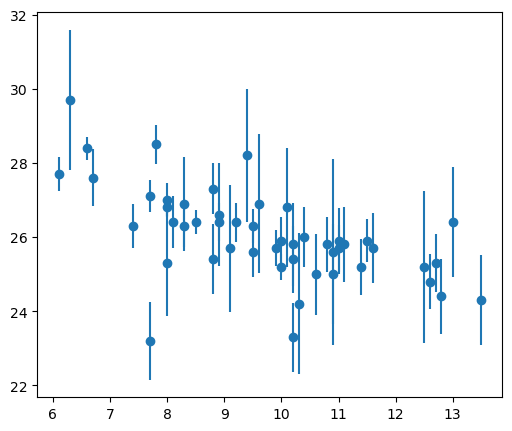

In [23]:
d = pd.read_csv("./data/WaffleDivorce.csv", sep=";")

plt.errorbar(x=d['Divorce'], y=d['MedianAgeMarriage'], yerr=d['Divorce SE'], fmt='o');

In the above plot, the lenght of the vertical lines show how uncertain the observed divorce rate is.

### 15.1.1 Error on the outcome

##### Code 15.3

In [41]:
dlist = dict(
  D_obs=d.Divorce.pipe(lambda x: (x - x.mean()) / x.std()).values.astype(np.float32),
  D_sd=(d["Divorce SE"].values / d.Divorce.std()).astype(np.float32),
  M=d.Marriage.pipe(lambda x: (x - x.mean()) / x.std()).values.astype(np.float32),
  A=d.MedianAgeMarriage.pipe(lambda x: (x - x.mean()) / x.std()).values.astype(np.float32)
)

In [38]:
def model_15_1(A, M, D_sd):
	def _generator():
		a = yield tfd.Normal(loc=0.0, scale=0.2, name="a")
		bA = yield tfd.Normal(loc=0.0, scale=0.5, name="bA")
		bM = yield tfd.Normal(loc=0.0, scale=0.5, name="bM")
		sigma = yield tfd.Exponential(rate=1.0, name="sigma")
		mu = a + bA * A + bM * M
		D_true = yield tfd.Normal(loc=mu, scale=sigma, name='D_true')
		yield tfd.Normal(loc=D_true, scale=D_sd, name='D_obs')

	return tfd.JointDistributionCoroutineAutoBatched(_generator)

In [42]:
jd_15_1 = model_15_1(dlist["A"], dlist["M"], dlist["D_sd"])

In [43]:
jd_15_1_pin = jd_15_1.experimental_pin(D_obs=dlist["D_obs"])

In [48]:
@jax.jit
def run_chain(init_state, seed, step_size=1e-3, num_steps=500, burnin=1000):

  def target_log_prob(*states):
    return jd_15_1_pin.unnormalized_log_prob(states)
  
  bijectors = [tfb.Identity(), tfb.Identity(), tfb.Identity(),
               tfb.Exp(), tfb.Identity()]

  kernel = tfp.mcmc.NoUTurnSampler(
      target_log_prob_fn=target_log_prob,
      step_size=step_size)
  
  kernel = tfp.mcmc.TransformedTransitionKernel(
    inner_kernel=kernel,
    bijector=bijectors)

  kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(
    inner_kernel=kernel,
    num_adaptation_steps=burnin)

  chain_state = tfp.mcmc.sample_chain(
      num_results=num_steps,
      num_burnin_steps=burnin,
      current_state=init_state,
      kernel=kernel,
      seed=seed,
      trace_fn=None)
  
  return chain_state

In [49]:
num_chains = 4
init_state = jd_15_1_pin.sample_unpinned(num_chains, seed=key())
post_1 = run_chain(init_state=init_state, seed=key())

In [50]:
post_1_dict = {k: jnp.moveaxis(v, 0, 1) for k, v in post_1._asdict().items()}
dict_1 = dict(posterior=post_1_dict)
idata_1 = az.from_dict(**dict_1)

In [51]:
az.summary(idata_1, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
D_true[0],1.159,0.369,0.604,1.763,0.011,0.008,1141.0,496.0,1.00
D_true[1],0.690,0.532,-0.107,1.597,0.018,0.013,885.0,1107.0,1.00
D_true[2],0.433,0.344,-0.140,0.936,0.007,0.006,2302.0,1486.0,1.00
D_true[3],1.404,0.475,0.659,2.174,0.012,0.009,1480.0,1006.0,1.00
D_true[4],-0.899,0.135,-1.120,-0.703,0.003,0.002,2010.0,1117.0,1.00
D_true[5],0.662,0.408,0.008,1.289,0.010,0.008,1728.0,1169.0,1.01
D_true[6],-1.365,0.337,-1.917,-0.875,0.007,0.005,2438.0,1446.0,1.00
D_true[7],-0.336,0.479,-1.130,0.389,0.013,0.010,1335.0,1110.0,1.00
D_true[8],-1.899,0.593,-2.742,-0.868,0.019,0.013,1019.0,1305.0,1.00
D_true[9],-0.618,0.171,-0.895,-0.358,0.003,0.003,2454.0,1146.0,1.00


##### Code 15.5

What happens when there is a measurement error on predictor variables as well ?

In [86]:
dlist = dict(
  D_obs = d.Divorce.pipe(lambda x: (x - x.mean()) / x.std()).values.astype(jnp.float32),
	D_sd = (d["Divorce SE"].values / d.Divorce.std()).astype(jnp.float32),
	M_obs = d.Marriage.pipe(lambda x: (x - x.mean()) / x.std()).values.astype(jnp.float32),
	M_sd = (d["Marriage SE"].values / d.Marriage.std()).astype(jnp.float32),
	A = d.MedianAgeMarriage.pipe(lambda x: (x - x.mean()) / x.std()).values.astype(jnp.float32),
	N = d.shape[0]
)

In [90]:
def model_15_2(A, M_sd, D_sd, N):
	def _generator():
		a = yield tfd.Normal(loc=0.0, scale=0.2, name="a")
		bA = yield tfd.Normal(loc=0.0, scale=0.5, name="bA")
		bM = yield tfd.Normal(loc=0.0, scale=0.5, name="bM")
		sigma = yield tfd.Exponential(rate=1.0, name="sigma")
		M_true = yield tfd.Sample(tfd.Normal(loc=0.0, scale=1.0), sample_shape=N, name="M_true")
		yield tfd.Normal(loc=M_true, scale=M_sd, name="M_obs")
		mu = a + bA * A + bM * M_true
		D_true = yield tfd.Normal(loc=mu, scale=sigma, name='D_true')
		yield tfd.Normal(loc=D_true, scale=D_sd, name='D_obs')

	return tfd.JointDistributionCoroutineAutoBatched(_generator)

In [91]:
jd_15_2 = model_15_2(dlist["A"], dlist["M_sd"], dlist["D_sd"], dlist['N'])

In [92]:
jd_15_2_pin = jd_15_2.experimental_pin(M_obs=dlist["M_obs"], D_obs=dlist["D_obs"])

In [93]:
@jax.jit
def run_chain(init_state, seed, step_size=1e-3, num_steps=500, burnin=1000):

  def target_log_prob(*states):
    return jd_15_2_pin.unnormalized_log_prob(states)
  
  bijectors = [tfb.Identity(), tfb.Identity(), tfb.Identity(),
               tfb.Exp(), tfb.Identity(), tfb.Identity(),]

  kernel = tfp.mcmc.NoUTurnSampler(
      target_log_prob_fn=target_log_prob,
      step_size=step_size)
  
  kernel = tfp.mcmc.TransformedTransitionKernel(
    inner_kernel=kernel,
    bijector=bijectors)

  kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(
    inner_kernel=kernel,
    num_adaptation_steps=burnin)

  chain_state = tfp.mcmc.sample_chain(
      num_results=num_steps,
      num_burnin_steps=burnin,
      current_state=init_state,
      kernel=kernel,
      seed=seed,
      trace_fn=None)
  
  return chain_state

In [94]:
num_chains = 4
init_state = jd_15_2_pin.sample_unpinned(num_chains, seed=key())
post_2 = run_chain(init_state=init_state, seed=key())

In [95]:
post_2_dict = {k: jnp.moveaxis(v, 0, 1) for k, v in post_2._asdict().items()}
dict_2 = dict(posterior=post_2_dict)
idata_2 = az.from_dict(**dict_2)

In [96]:
az.summary(idata_2, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
D_true[0],1.126,0.350,0.577,1.663,0.007,0.005,2396.0,1264.0,1.0
D_true[1],0.765,0.564,-0.093,1.697,0.013,0.011,1765.0,1350.0,1.0
D_true[2],0.423,0.336,-0.111,0.923,0.006,0.006,3288.0,1540.0,1.0
D_true[3],1.460,0.456,0.761,2.241,0.010,0.008,2007.0,1264.0,1.0
D_true[4],-0.895,0.132,-1.102,-0.687,0.003,0.002,2031.0,1189.0,1.0
...,...,...,...,...,...,...,...,...,...
M_true[49],1.273,0.705,0.249,2.455,0.022,0.015,1046.0,1187.0,1.0
a,-0.044,0.099,-0.193,0.123,0.002,0.002,1911.0,1675.0,1.0
bA,-0.546,0.159,-0.807,-0.305,0.005,0.003,1162.0,1565.0,1.0
bM,0.201,0.209,-0.134,0.529,0.007,0.005,818.0,1264.0,1.0


##### Code 15.6

In [97]:
post_2_dict["D_true"].shape

(4, 500, 50)

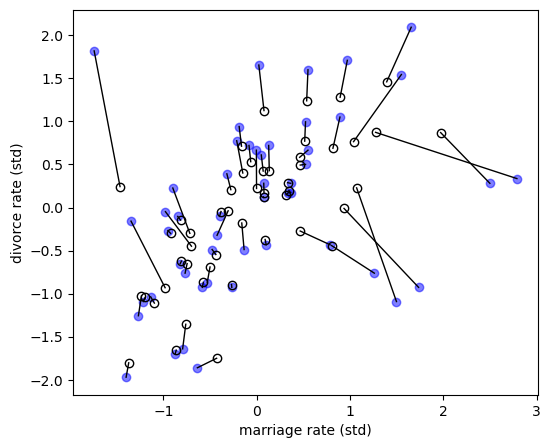

In [98]:
post_D_true = post_2_dict["D_true"]
post_M_true = post_2_dict["M_true"]

D_est = jnp.mean(post_D_true, axis=(0, 1))
M_est = jnp.mean(post_M_true, axis=(0, 1))
plt.plot(dlist["M_obs"], dlist["D_obs"], "bo", alpha=0.5)
plt.gca().set(xlabel="marriage rate (std)", ylabel="divorce rate (std)")
plt.plot(M_est, D_est, "ko", mfc="none")
for i in range(dlist["N"]):
    plt.plot([dlist["M_obs"][i], M_est[i]], [dlist["D_obs"][i], D_est[i]], "k-", lw=1)

Above figure demonstrates shrinkage of both divorce rate and marriage rate. Solid points are the observed values. Open points are posterior means. Lines connect pairs of points for the same state. Both variables are shrunk towards the inferred regression relationship.

## 15.2 Missing data

### 15.2.2 Imputing primates

##### Code 15.16

In [2]:
d = pd.read_csv("./data/milk.csv", sep=";")
d["neocortex.prop"] = d["neocortex.perc"] / 100
d["logmass"] = d.mass.apply(np.log)

In [3]:
dat_list = dict(
	K=jnp.array(d["kcal.per.g"].pipe(lambda x: (x - x.mean()) / x.std()).values),
	B=jnp.array(d["neocortex.prop"].pipe(lambda x: (x - x.mean()) / x.std()).values),
	M=jnp.array(d.logmass.pipe(lambda x: (x - x.mean()) / x.std()).values)
)

In [4]:
dat_list["B_impute_idx"] = jnp.isnan(dat_list['B'])
dat_list["B_impute_N"] = dat_list["B_impute_idx"].sum()
dat_list["N"] = dat_list['M'].shape

In [38]:
def gen_B_likelihood(nu, sigma_B):
		def _generator():
			yield tfd.Normal(loc=nu, scale=sigma_B, name='B_merged')
		return tfd.JointDistributionCoroutineAutoBatched(_generator)

bb = gen_B_likelihood(0., 1.)
bbb = bb.experimental_pin(B_merged=jnp.array([.1, .2]))
bbb.log_prob()

Array([-0.9239385, -0.9389385], dtype=float32)

# TODO
TFP should include the fuctionality equivalent to numpyro's (1) numpyro.deterministic() and (2) **obs** argument, such as numpyro.sample("x", dist.Normal(mu, sigma), obs=x).

In [20]:
# def model_15_5(M, B_obs, B_impute_idx, B_impute_N):
	
# 	def _generator():
# 		a = yield tfd.Normal(loc=0.0, scale=0.5, name="a")
# 		nu = yield tfd.Normal(loc=0.0, scale=0.5, name="nu")
# 		bB = yield tfd.Normal(loc=0.0, scale=0.5, name="bB")
# 		bM = yield tfd.Normal(loc=0.0, scale=0.5, name="bM")
# 		sigma_B = yield tfd.Exponential(rate=1.0, name="sigma_B")
# 		sigma = yield tfd.Exponential(rate=1.0, name="sigma")
# 		B_impute = yield tfd.Sample(
# 			tfd.Normal(loc=0.0, scale=1.0), sample_shape=B_impute_N, name="B_impute")
# 		B_merged = B_obs.at[B_impute_idx].set(B_impute)
# 		B_ll = tfd.Normal(loc=nu, scale=sigma_B).log_prob(B_merged).sum()
# 		yield tfd.Deterministic(B_ll, name="B_ll")
# 		mu = a + bB * B_merged + bM * M
# 		yield tfd.Normal(loc=mu, scale=sigma, name='K')

# 	return tfd.JointDistributionCoroutineAutoBatched(_generator)

In [21]:
# jd_15_5 = model_15_5(dat_list["M"], dat_list["B"], dat_list["B_impute_idx"], 
#                      dat_list['B_impute_N'])

In [ ]:
# jd_15_5.sample(seed=key())._fields

In [35]:
# @jax.jit
# def run_chain(init_state, seed, step_size=1e-3, num_steps=500, burnin=500):

#   def target_log_prob(a, nu, bB, bM, sigma_B, sigma, B_impute, B_ll, K):
#     # a, nu, bB, bM, sigma_B, sigma, B_impute, B, K = states
#     # B_ll = tfd.Sample(tfd.Normal(loc=nu, scale=sigma_B), sample_shape=29).log_prob(B)
#     return  B_ll + \
#       jd_15_5.log_prob(
#         a=a, nu=nu, bB=bB, bM=bM, sigma_B=sigma_B, sigma=sigma, 
#         B_impute=B_impute, B_ll=B_ll, K=dat_list["K"])
  
#   bijectors = [tfb.Identity(), tfb.Identity(), tfb.Identity(), tfb.Identity(),
#                tfb.Exp(), tfb.Exp(), tfb.Identity(), tfb.Identity(), tfb.Identity()]

#   kernel = tfp.mcmc.NoUTurnSampler(
#       target_log_prob_fn=target_log_prob,
#       step_size=step_size)
  
#   kernel = tfp.mcmc.TransformedTransitionKernel(
#     inner_kernel=kernel,
#     bijector=bijectors)

#   kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(
#     inner_kernel=kernel,
#     num_adaptation_steps=burnin)

#   chain_state = tfp.mcmc.sample_chain(
#       num_results=num_steps,
#       num_burnin_steps=burnin,
#       current_state=init_state,
#       kernel=kernel,
#       seed=seed,
#       trace_fn=None)
  
#   return chain_state

In [ ]:
# num_chains = 2
# init_state = jd_15_5.sample(num_chains, seed=key())
# post_5 = run_chain(init_state=init_state, seed=key())

In [25]:
# post_5_dict = {k: jnp.moveaxis(v, 0, 1) for k, v in post_5._asdict().items()}
# dict_5 = dict(posterior=post_5_dict)
# idata_5 = az.from_dict(**dict_5)

In [ ]:
# summary_5 = az.summary(idata_5, hdi_prob=0.89)

In [ ]:
# summary_5[summary_5.index.str.startswith(('B'))]